In this code, we assume the following notation for the Standard Hopfield model:
- N is the size of the patterns;
- M is the number of patterns that we want to store;
- $\xi^\mu \in [-1,1]^N$, is the $\mu$-th stored pattern, with $\mu = 1,...,M$;
- $\sigma \in [-1,1]^N$ is a generic configuration.


The energy of a given configuration $\sigma$ is given by:
$$
E(\sigma) = - \sum_{\mu = 1}^{M} exp(\sigma \cdot \xi_\mu )
$$

In [1]:
import modern_hopfield_binary as mh
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, prange, njit
import time
import math
from scipy import optimize
from scipy.optimize import curve_fit
from scipy import stats

In [2]:
def reconstruction_probability(N, pp, α, nsweeps, ntrials, nsamples, β = 100, earlystop = 0,
                               save = False, plot = False):
    
    #define the corruption probabilities and the number of stored patterns
    M = math.floor(N * α)
    
    #initialize vectors to contain final probabilities and relative errorbars
    probs = np.zeros(len(pp))
    error_bars = np.zeros(len(pp))
    
    #loop over corruption probabilities
    for i in range(len(pp)):
    
        #initialize array to average over samples later
        probs_over_samples = np.zeros(nsamples)

        #loop over samples
        for sample in range(nsamples):
            ξ = mh.multiple_patterns(M, N) #create M patterns of length N
            #J = mh.storing(ξ) # store the patterns into the matrix J

            # select a random pattern, corrupt it with probability pp[i] and try to reconstruct the original
            # ntrials times
            k = np.random.randint(M)
            corrupted_ξ = mh.corruption(ξ[k], pp[i])

            count = 0 # count the number of times that the pattern is correctly reconstructed
            for trial in prange(ntrials):
                σ = corrupted_ξ.copy()
                
                # metropolis algorithm for nsweeps iterations
                for s in prange(nsweeps):
                        σ, fliprate = mh.metropolis(σ, ξ, β = 100)
                        
                        # earlystop if fliprate <= earlystop
                        if fliprate <= earlystop: break
                            
                m = mh.overlap(σ, ξ[k]) / N # compute the overlap

                if m >= 0.95: count += 1 # consider a success if m is >= 0.95
                    
            probs_over_samples[sample] = count/ntrials # fraction of times that the pattern was reconstructed
                                                       # succesfully

        probs[i] = np.mean(probs_over_samples) # average over samples
        error_bars[i] = np.std(probs_over_samples) / np.sqrt(nsamples) # error of the average
    
    # plot the results
    if plot:
        size = 12
        #plt.plot(pp, probs_15, c = "red", marker = "None", linestyle = "None", linewidth = 1)
        plt.errorbar(pp, probs, yerr = error_bars, c = "darkorange", ecolor = "black", linestyle = "--", linewidth = 1,
                     marker = "o", markerfacecolor = "None", markersize = 4, capsize = 2, label = "N = {}, M = {}".format(N, M))
        plt.xlabel("p (probability of corruption)", size = size)
        plt.ylabel("Prob", size = size)
        plt.title("Probability of reconstruction for different corruption probabilities")
        plt.legend(fontsize = size)
        plt.grid(axis = "both", linestyle = "--", linewidth = .7, alpha = 0.5)
        plt.show()
        
    # save the results 
    if save:
        np.savetxt('saved_data/standard_hopfield/probs_N{}_α{}'.format(N, α), np.vstack((pp, probs, error_bars)).T, delimiter=', ', fmt = "%f")
    return probs, error_bars

In [4]:
%%time

N = np.array([50])
parameters = {
    "pp": np.linspace(0.02, 0.9, 25),
    "α": 1,
    "nsweeps": 70,
    "ntrials": 100,
    "nsamples": 100,
    "β": 10**3,
    "earlystop": 0,
    "plot": True,
    "save": False
}

for n in N:
    print("Starting simulation for N = {}".format(n), "\n...")
    p, e = reconstruction_probability(n, **parameters)
    print("Done!\n\n")

Starting simulation for N = 50 
...


SystemError: CPUDispatcher(<function metropolis at 0x7fb1e2218670>) returned a result with an error set

Starting simulation for N = 1000 
...


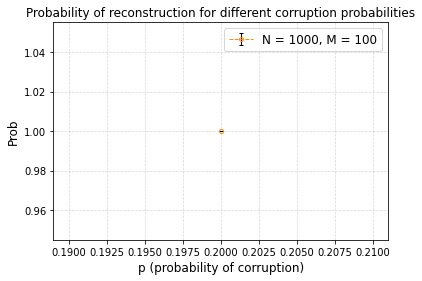

Done!


CPU times: user 706 ms, sys: 40.3 ms, total: 746 ms
Wall time: 685 ms


In [5]:
%%time

N = np.array([1000])
parameters = {
    "pp": np.array([0.2]),
    "α": 0.1,
    "nsweeps": 100,
    "ntrials": 1,
    "nsamples": 1,
    "β": 10**3,
    "earlystop": 0,
    "plot": True,
    "save": False
}

for n in N:
    print("Starting simulation for N = {}".format(n), "\n...")
    p, e = reconstruction_probability(n, **parameters)
    print("Done!\n\n")

In [45]:
%%time
N = 1000
M = int(N*0.1)
earlystop = -1
nsweeps = 100
ξ = mh.multiple_patterns(M, N) #create M patterns of length N
k = 0
corrupted_ξ = mh.corruption(ξ[k], 0.2)
σ = corrupted_ξ.copy()
for s in prange(nsweeps):
    σ, fliprate = mh.metropolis(σ, ξ, β = 100)

    # earlystop if fliprate <= earlystop
    if fliprate <= earlystop: break

CPU times: user 7.79 s, sys: 11.1 ms, total: 7.81 s
Wall time: 7.81 s


In [55]:
def ΔE(σ, ξ):
    M = ξ.shape[0]
    i = 0
    ΔE = 0
    for μ in prange(M):
        orig_ξ = ξ[μ]
        overlap_in = overlap(orig_ξ, σ)
        ΔE -= np.exp( overlap_in ) * ( np.exp( - 2. * orig_ξ[i] * σ[i]) - 1 )
    return ΔE

In [56]:
%%time
ξ = mh.multiple_patterns(M, N) #create M patterns of length N
k = 0
corrupted_ξ = mh.corruption(ξ[k], 0.2)
σ = corrupted_ξ.copy()
ΔE(σ, ξ)

CPU times: user 2.9 ms, sys: 672 µs, total: 3.57 ms
Wall time: 2.42 ms


-1.0944124486248349e+257

In [ ]:
def ΔE1(σ, ξ):
    M = ξ.shape[0]
    i = 0
    ΔE = 0

    for μ in prange(M):
        orig_ξ = ξ[μ]
        overlap_in = overlap(orig_ξ, σ)
        ΔE -= np.exp( overlap_in ) * ( np.exp( - 2. * orig_ξ[i] * σ[i]) - 1 )
    return ΔE

In [11]:
a = mh.init_pattern(1000)
b = mh.init_pattern(1000)

In [12]:
%%time
mh.overlap(a, b)

CPU times: user 15 µs, sys: 0 ns, total: 15 µs
Wall time: 17.9 µs


-18